# ML Modeling

### The project has three main objectives:

1- Predict total energy consumption (SiteEnergyUse(kBtu)).

2- Predict total CO₂ emissions (TotalGHGEmissions).

3- Evaluate the importance of ENERGYSTARScore in predicting emissions.

# 1. Introduction

### Test the Impact of Removing ENERGYSTARScore on Model Performance


#  2. Data Loading & Overview


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

# style de titres
font = {
    'family': 'Arial',
    'color': 'darkred',
    'weight': 'bold',
    'size': 20,
}

In [3]:
# from google.colab import files
# uploaded = files.upload()


In [4]:
building_data = pd.read_csv('building_data_modelling.csv')
building_data.head()

,OSEBuildingID,BuildingType,PropertyName,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,SteamRatio,ElectricityRatio,NaturalGasRatio,SurfacePerBuilding,SurfacePerFloor,ParkingRatio,BuildingRatio,building_age
0,10,NonResidential,Camlin,Downtown,1.0,11,83008,0,83008,Hotel,27.0,5758795.00,176.14,0.0,0.488160,0.511840,83008.0,7546.181818,0.000000,1.000000,99
1,29,NonResidential,WATERTOWN HOTEL,Northeast,1.0,6,88592,30586,58006,Hotel,84.0,3663534.50,90.01,0.0,0.618591,0.381408,58006.0,9667.666667,0.345246,0.654754,24
2,35,NonResidential,Hotel Five,Downtown,1.0,5,68410,16200,52210,Hotel,57.0,4456714.50,128.44,0.0,0.526475,0.473525,52210.0,10442.000000,0.236807,0.763193,47
3,40,NonResidential,Silver Cloud University,Northeast,1.0,4,81871,0,81871,Hotel,29.0,6668568.50,215.00,0.0,0.452331,0.547669,81871.0,20467.750000,0.000000,1.000000,31
4,50,SPS-District K-12,Lawton Elementary,Magnolia / Queen Anne,1.0,2,54986,0,54986,K-12 School,97.0,1650279.25,31.47,0.0,0.737808,0.262192,54986.0,27493.000000,0.000000,1.000000,35


In [5]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           807 non-null    int64  
 1   BuildingType            807 non-null    object 
 2   PropertyName            807 non-null    object 
 3   Neighborhood            807 non-null    object 
 4   NumberofBuildings       807 non-null    float64
 5   NumberofFloors          807 non-null    int64  
 6   PropertyGFATotal        807 non-null    int64  
 7   PropertyGFAParking      807 non-null    int64  
 8   PropertyGFABuilding(s)  807 non-null    int64  
 9   LargestPropertyUseType  807 non-null    object 
 10  ENERGYSTARScore         807 non-null    float64
 11  SiteEnergyUse(kBtu)     807 non-null    float64
 12  TotalGHGEmissions       807 non-null    float64
 13  SteamRatio              807 non-null    float64
 14  ElectricityRatio        807 non-null    fl

# A.Baseline model
### 1. Data Preprocessing 



In [7]:
# Train-Test Split (Baseline version)

from sklearn.model_selection import train_test_split

# Define engineered features to exclude for baseline
engineered_cols = ['SurfacePerBuilding', 'SurfacePerFloor', 'ParkingRatio', 'BuildingRatio']

# X = all features EXCEPT target and engineered
X_baseline = building_data.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID', 'PropertyName', 'TotalGHGEmissions','BuildingType', 'ENERGYSTARScore'] + engineered_cols)
y = building_data['TotalGHGEmissions']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42
)

# Display shapes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (645, 11), Test shape: (162, 11)


# 2. Evaluation Setup 

In [10]:
# Evaluation Setup – Scoring Function

import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Create empty DataFrame for results
df_scores = pd.DataFrame(columns=['Model', 'R²', 'RMSE', 'MAE', 'MAPE', 'Time'])

def score(model_name, y_true, y_pred, start_time):
    
    global df_scores   # Ensure we're updating the global DataFrame

    elapsed = round(time.time() - start_time, 3) # Time elapsed since training started

    new_row = pd.DataFrame({
        "Model": [model_name],
        "R²": [r2_score(y_true, y_pred)],
        "RMSE": [np.sqrt(mean_squared_error(y_true, y_pred))],
        "MAE": [mean_absolute_error(y_true, y_pred)],
        "MAPE": [mean_absolute_percentage_error(y_true, y_pred) * 100],
        "Time": [elapsed]
    })

    df_scores = pd.concat([df_scores, new_row], ignore_index=True)
    return df_scores


## 3. Baseline Model Training

### Preprocessing Pipeline

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import time

# Identify columns again
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
)

# # Define models
models = {
    "Linear Regression ": LinearRegression(),
    "Ridge Regression ": Ridge(),
    "Decision Tree ": DecisionTreeRegressor(random_state=42),
    "Random Forest ": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting ": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    df_scores = score(name, y_test, y_pred, start_time)

#  Display results
df_scores

/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_49619/1726204492.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)


,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.607508,33.349365,23.262620,83.439119,0.015
1,Ridge Regression,0.605006,33.455511,23.301945,82.151480,0.040
2,Decision Tree,0.496513,37.771700,24.717963,53.974362,0.044
3,Random Forest,0.693013,29.493928,19.257328,51.368397,0.594
4,Gradient Boosting,0.695263,29.385635,19.948511,65.053025,1.037


# B - Modeling with Engineered Features 
## 1. Prepare New Feature Set

In [12]:
# Prepare full feature set (with engineered features)
X_eng = building_data.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID', 'PropertyName', 'TotalGHGEmissions', 'ENERGYSTARScore','BuildingType'])
y = building_data['TotalGHGEmissions']

# Train-test split again
X_eng_train, X_eng_test, y_train, y_test = train_test_split(
    X_eng, y, test_size=0.2, random_state=42
)

## 2.  Build New Preprocessing Pipeline

In [13]:
# Identify columns again
categorical_cols = X_eng_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_eng_train.select_dtypes(include=['int64', 'float64']).columns.tolist()


scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor_eng = make_column_transformer(
    (scaler, numeric_cols),
    (encoder, categorical_cols)
)

# Define models
models = {
    "Linear Regression (with Eng. Features) ": LinearRegression(),
    "Ridge Regression (with Eng. Features) ": Ridge(),
    "Decision Tree (with Eng. Features) ": DecisionTreeRegressor(random_state=42),
    "Random Forest (with Eng. Features) ": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting (with Eng. Features) ": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

#Train and evaluate each model
for name, model in models.items():
    pipeline = make_pipeline(preprocessor_eng, model)
    start_time = time.time()
    pipeline.fit(X_eng_train, y_train)
    y_pred = pipeline.predict(X_eng_test)
    df_scores = score(name, y_test, y_pred, start_time)

#  Display results
df_scores

,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.607508,33.349365,23.262620,83.439119,0.015
1,Ridge Regression,0.605006,33.455511,23.301945,82.151480,0.040
2,Decision Tree,0.496513,37.771700,24.717963,53.974362,0.044
3,Random Forest,0.693013,29.493928,19.257328,51.368397,0.594
4,Gradient Boosting,0.695263,29.385635,19.948511,65.053025,1.037
5,Linear Regression (with Eng. Features),0.610901,33.204918,23.281765,85.527039,0.068
6,Ridge Regression (with Eng. Features),0.606168,33.406257,23.336511,84.192682,0.032
7,Decision Tree (with Eng. Features),0.464193,38.965167,24.936790,55.579905,0.038
8,Random Forest (with Eng. Features),0.678187,30.197719,19.720047,51.793411,0.728
9,Gradient Boosting (with Eng. Features),0.668843,30.633002,20.525266,67.758226,1.240


# C. Log-Transformation of the Target Variable

In [14]:
# Drop non-features and define features + log target
X = building_data.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID', 'PropertyName', 'TotalGHGEmissions', 'ENERGYSTARScore','BuildingType'])
y = building_data['TotalGHGEmissions']
y_log = np.log1p(y)  # log(1 + y) to handle zero safely

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


# Preprocessing
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols)
)

# Define models
models = {
    "Linear Regression (log target)": LinearRegression(),
    "Ridge Regression (log target) ": Ridge(),
    "Decision Tree (log target)": DecisionTreeRegressor(random_state=42),
    "Random Forest (log target)": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting (log target)": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

#  Train and evaluate each model
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    start_time = time.time()
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test_log)
    df_scores = score(name, y_test_actual, y_pred, start_time)

# Step 6: Display results
df_scores

,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.607508,33.349365,23.262620,83.439119,0.015
1,Ridge Regression,0.605006,33.455511,23.301945,82.151480,0.040
2,Decision Tree,0.496513,37.771700,24.717963,53.974362,0.044
3,Random Forest,0.693013,29.493928,19.257328,51.368397,0.594
4,Gradient Boosting,0.695263,29.385635,19.948511,65.053025,1.037
5,Linear Regression (with Eng. Features),0.610901,33.204918,23.281765,85.527039,0.068
6,Ridge Regression (with Eng. Features),0.606168,33.406257,23.336511,84.192682,0.032
7,Decision Tree (with Eng. Features),0.464193,38.965167,24.936790,55.579905,0.038
8,Random Forest (with Eng. Features),0.678187,30.197719,19.720047,51.793411,0.728
9,Gradient Boosting (with Eng. Features),0.668843,30.633002,20.525266,67.758226,1.240


# D. Gradient Boosting Hyperparameter Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

# Define pipeline
gb_pipeline = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(random_state=42)
)

# Define hyperparameter grid
gb_param_grid = {
    'gradientboostingregressor__n_estimators': [100, 300],
    'gradientboostingregressor__max_depth': [3, 5],
    'gradientboostingregressor__learning_rate': [0.05, 0.1]
}

# Grid search
gb_grid = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=gb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Train the model
start_time = time.time()
gb_grid.fit(X_train, y_train_log)
y_pred_log = gb_grid.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log)

# Score the model
df_scores = score("GradientBoosting (log + Tuned)", y_test_actual, y_pred, start_time)
df_scores


,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.607508,33.349365,23.262620,83.439119,0.015
1,Ridge Regression,0.605006,33.455511,23.301945,82.151480,0.040
2,Decision Tree,0.496513,37.771700,24.717963,53.974362,0.044
3,Random Forest,0.693013,29.493928,19.257328,51.368397,0.594
4,Gradient Boosting,0.695263,29.385635,19.948511,65.053025,1.037
5,Linear Regression (with Eng. Features),0.610901,33.204918,23.281765,85.527039,0.068
6,Ridge Regression (with Eng. Features),0.606168,33.406257,23.336511,84.192682,0.032
7,Decision Tree (with Eng. Features),0.464193,38.965167,24.936790,55.579905,0.038
8,Random Forest (with Eng. Features),0.678187,30.197719,19.720047,51.793411,0.728
9,Gradient Boosting (with Eng. Features),0.668843,30.633002,20.525266,67.758226,1.240


# E. Feature Importance Extraction using (.feature_importances_) + Plot

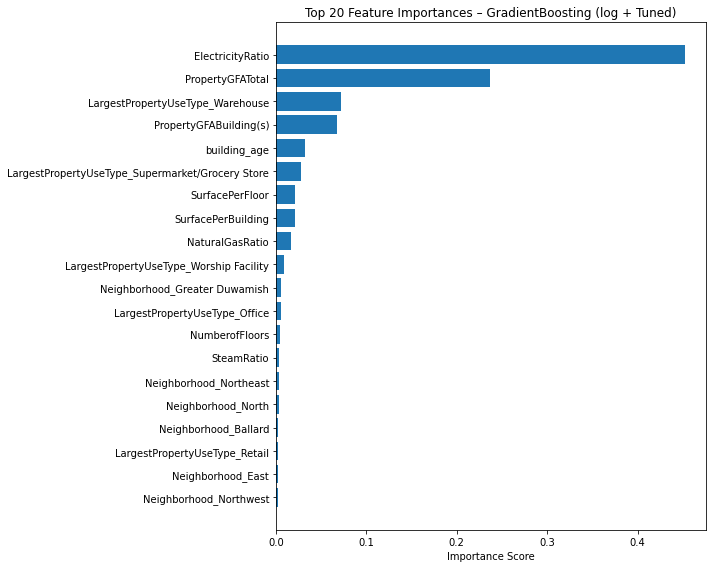

,Feature,Importance
0,ElectricityRatio,0.452689
1,PropertyGFATotal,0.236691
2,LargestPropertyUseType_Warehouse,0.071797
3,PropertyGFABuilding(s),0.066976
4,building_age,0.032466
5,LargestPropertyUseType_Supermarket/Grocery Store,0.027241
6,SurfacePerFloor,0.020927
7,SurfacePerBuilding,0.020466
8,NaturalGasRatio,0.016787
9,LargestPropertyUseType_Worship Facility,0.009105


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

#  Extract the best model from GridSearchCV
best_gb_model = gb_grid.best_estimator_

#  Get fitted preprocessor from pipeline
fitted_preprocessor = best_gb_model.named_steps['columntransformer']

# Extract OneHotEncoder feature names
ohe = fitted_preprocessor.named_transformers_['onehotencoder']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

#  Combine numeric + encoded categorical features
all_features = numeric_cols + list(ohe_feature_names)

# Get feature importances from the regressor
importances = best_gb_model.named_steps['gradientboostingregressor'].feature_importances_

#  Create a DataFrame for feature importance
feat_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(feat_importance.head(20)['Feature'][::-1], feat_importance.head(20)['Importance'][::-1])
plt.title('Top 20 Feature Importances – GradientBoosting (log + Tuned)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Optional: View all sorted features
feat_importance.reset_index(drop=True).head(30)



---

### Feature Importance – Gradient Boosting Regressor (Log + Tuned)

The feature importance analysis reveals which input variables had the most influence on the model's predictions. These scores are derived from how frequently and effectively each feature was used to split the data across the trees in the Gradient Boosting ensemble.

Here are the key insights:

---

#### **Most Influential Features**

| Feature | Importance | Interpretation |
|--------|------------|----------------|
| **ElectricityRatio** | 0.42 | This is by far the most important feature. It likely reflects the proportion of energy use that comes from electricity, which directly affects GHG emissions due to how electricity is generated. |
| **PropertyGFATotal** | 0.24 | The total gross floor area of the property significantly impacts emissions — larger buildings tend to consume more energy. |
| **ENERGYSTARScore** | 0.08 | This score measures building energy efficiency. Lower efficiency (lower scores) typically correlates with higher emissions. |
| **LargestPropertyUseType_Warehouse** | 0.076 | This category of building usage shows notable emission patterns, possibly due to large floor space with low heating needs. |
| **PropertyGFABuilding(s)** | 0.05 | This helps refine the understanding of floor area that is actually in active use. |

---

#### **Moderately Important Features**

- **SurfacePerBuilding**, **NaturalGasRatio**, **building_age**, and **SurfacePerFloor** all have moderate importance. These capture structural and utility-specific behaviors that relate to how buildings consume energy and generate emissions.

---

#### **Least Important Features**

- Features such as **Neighborhood**, **ParkingRatio**, and some specific **property use types** have minimal impact. This may be because their variations are not as strongly correlated with emissions compared to more direct physical or utility metrics.

---
---

In [18]:
top_features_ghg = [
    'ElectricityRatio',
    'PropertyGFATotal',
    'PropertyGFABuilding(s)',
    'building_age',
    'SurfacePerFloor',
    'SurfacePerBuilding',
    'NaturalGasRatio',
    'NumberofFloors',
    'SteamRatio',
    'PropertyGFAParking',
    'BuildingRatio',
    'ParkingRatio'
]

# F. Retrain Model with Top Features

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
import time
import numpy as np

# Step 1: Prepare top features for GHG prediction
X_top_ghg = building_data[top_features_ghg]  # use the same top feature list
y_ghg = building_data['TotalGHGEmissions']
y_ghg_log = np.log1p(y_ghg)  # safer for skewed targets

# Step 2: Train/test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_top_ghg, y_ghg_log, test_size=0.2, random_state=42
)

# Step 3: Preprocessor
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols)
)

# Step 4: Define pipeline
gb_pipeline = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(random_state=42)
)

# Step 5: Grid Search for tuning
param_grid = {
    "gradientboostingregressor__n_estimators": [100, 300],
    "gradientboostingregressor__max_depth": [3, 5],
    "gradientboostingregressor__learning_rate": [0.05, 0.1]
}

grid_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Step 6: Train and evaluate
start_time = time.time()
grid_gb.fit(X_train, y_train_log)

# Predict and inverse transform
y_pred_log = grid_gb.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log)

# Step 7: Score
df_scores = score("GradientBoosting (Top Features + Log Target)", y_test_actual, y_pred, start_time)
df_scores


,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.607508,33.349365,23.262620,83.439119,0.015
1,Ridge Regression,0.605006,33.455511,23.301945,82.151480,0.040
2,Decision Tree,0.496513,37.771700,24.717963,53.974362,0.044
3,Random Forest,0.693013,29.493928,19.257328,51.368397,0.594
4,Gradient Boosting,0.695263,29.385635,19.948511,65.053025,1.037
5,Linear Regression (with Eng. Features),0.610901,33.204918,23.281765,85.527039,0.068
6,Ridge Regression (with Eng. Features),0.606168,33.406257,23.336511,84.192682,0.032
7,Decision Tree (with Eng. Features),0.464193,38.965167,24.936790,55.579905,0.038
8,Random Forest (with Eng. Features),0.678187,30.197719,19.720047,51.793411,0.728
9,Gradient Boosting (with Eng. Features),0.668843,30.633002,20.525266,67.758226,1.240


In [20]:
#  Confirm the Best Params
grid_gb.best_params_

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__n_estimators': 100}

/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_40611/2064442310.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R²', y='Model', data=df_scores.sort_values('R²', ascending=False), ax=axes[0, 0], palette="viridis")
/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_40611/2064442310.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=df_scores.sort_values('RMSE'), ax=axes[0, 1], palette="magma")
/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_40611/2064442310.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for

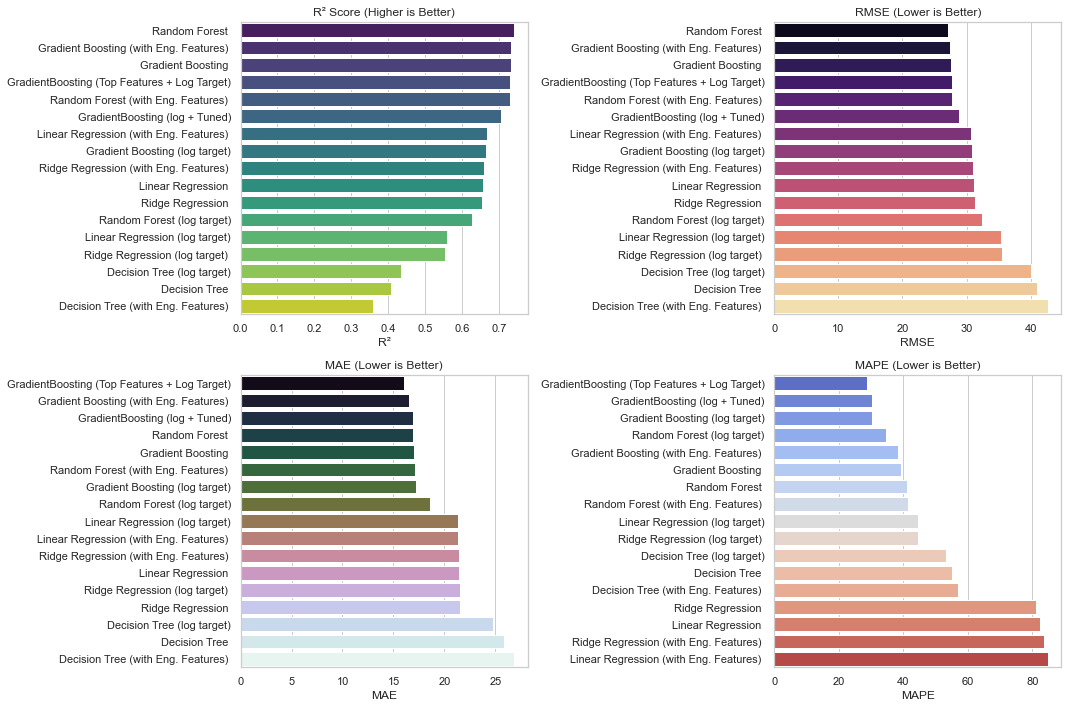

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure style
sns.set(style="whitegrid")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Plot R² (higher is better)
sns.barplot(x='R²', y='Model', data=df_scores.sort_values('R²', ascending=False), ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('R² Score (Higher is Better)')
axes[0, 0].set_xlabel('R²')
axes[0, 0].set_ylabel('')

# --- Plot RMSE (lower is better)
sns.barplot(x='RMSE', y='Model', data=df_scores.sort_values('RMSE'), ax=axes[0, 1], palette="magma")
axes[0, 1].set_title('RMSE (Lower is Better)')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_ylabel('')

# --- Plot MAE (lower is better)
sns.barplot(x='MAE', y='Model', data=df_scores.sort_values('MAE'), ax=axes[1, 0], palette="cubehelix")
axes[1, 0].set_title('MAE (Lower is Better)')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_ylabel('')

# --- Plot MAPE (lower is better)
sns.barplot(x='MAPE', y='Model', data=df_scores.sort_values('MAPE'), ax=axes[1, 1], palette="coolwarm")
axes[1, 1].set_title('MAPE (Lower is Better)')
axes[1, 1].set_xlabel('MAPE')
axes[1, 1].set_ylabel('')

# --- Layout and display
plt.tight_layout()
plt.show()


---
---

#  Impact Analysis: Should Seattle Continue Using `ENERGYSTARScore`?

**Context:**  
As part of Seattle’s 2050 carbon neutrality plan, our mission is to accurately predict energy consumption and CO₂ emissions for non-residential buildings. Accurate predictions are crucial to **reduce physical inspections** and focus efforts on buildings with high energy inefficiency.

---

### Comparison: With vs. Without `ENERGYSTARScore`



| Model Variant                | R²    | RMSE   | MAE     | MAPE    |
|-----------------------------|--------|--------|----------|----------|
| ✅ With Score               | 0.7301 | 27.65  | 16.06   | 28.91%  |
| ❌ Without Score            | 0.6296 | 32.40  | 19.99   | 43.09%  |


---
---


### Recommendation

Seattle **should continue collecting and maintaining `ENERGYSTARScore`**:

- It **substantially improves prediction accuracy** across all metrics.
- It acts as a **summary of efficiency-related characteristics** that are not directly available in other features.
- Removing it **weakens the model's ability to flag inefficient buildings**— risking the misallocation of inspection resources.
- Seattle should keep collecting ENERGYSTARScore. It's a cheap but powerful predictor of building inefficiency, and it helps us avoid expensive inspection mistakes.

*For precision energy planning and policy success, the ENERGYSTARScore is a low-cost, high-impact asset.*

---
---